   # Prepare Labels and Features Datasets

  - Get SMILES for all compounds 
  - Remove rows with NaN / None SMILE values 
  - get TPSA for remaining compounds
  - add Ln(TPSA) and Log(TPSA)
  - 
**Input Files**
  -   `/input/compound.csv  OR ./output/cp_compound_metadata.csv`

**Intermediate Files**
  -   

**Output Files**
  - `compound_pharmacophores_sparse_clean.pkl`  File of compound pharmacophores in sparse format


# Setup

In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload  
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [31]:
import os
import sys
import argparse
import csv
import json
import time
import types, copy, pprint
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from utils import getTPSAFromRDKit, getSmilesFromRDKit

pp = pprint.PrettyPrinter(indent=4)
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')
pd.options.display.width = 132

os.environ["WANDB_NOTEBOOK_NAME"] = "Adashare_Train.ipynb"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [5]:
# from chembl_webresource_client.new_client import new_client
# from chembl_webresource_client.utils import utils
# import pubchempy as pcp

In [6]:
# import rdkit
# from rdkit.Chem import inchi
# from rdkit.Chem import INCHI_AVAILABLE
# from rdkit import Chem
# from rdkit.Chem.Draw import IPythonConsole
# from rdkit.Chem import Draw
# IPythonConsole.ipython_useSVG=True  #< set this to False if you want PNGs instead of SVGs
# import rdkit.Avalon.pyAvalonTools as pat
# import rdkit.Chem.MolStandardize as rdms
# from rdkit.Chem import ChemicalFeatures
# from rdkit import RDConfig
# from rdkit.Chem import AllChem
# from rdkit.Chem.Pharm2D import Generate
# from rdkit.Chem.Pharm2D import Gobbi_Pharm2D

# if INCHI_AVAILABLE:
#   from rdkit.Chem import InchiReadWriteError
#   from rdkit.Chem import MolToInchi, MolBlockToInchi, MolFromInchi, InchiToInchiKey, MolToInchiKey, MolFromMolFile, MolToMolFile
# else:
#     print('INCHI not available')

In [7]:
input_path ="./metadata/"
output_path ="./output_11102023/"
prefix = '' ### Target-2' , 'MOA'
prefix_lc = prefix.lower().replace('-', '_')
 
# compoundMetadataInputFile   = f"{input_path}JUMP-{prefix}_compound_library.csv"

compoundMetadataInputFile         = f"{input_path}{prefix_lc}compound.csv"
plateMetadataInputFile            = f"{input_path}{prefix_lc}plate_new.csv"
wellMetadataInputFile             = f"{input_path}{prefix_lc}well_new.csv"

compoundMetadataSmilesFile         = f"{output_path}{prefix_lc}compound_metadata_smiles.csv"
compoundMetadataSmilesCleanFile    = f"{output_path}{prefix_lc}compound_metadata_smiles_clean.csv"

compoundMetadataCleanFile          = f"{output_path}{prefix_lc}compound_metadata_clean.csv"

compoundMetadataTPSAFile           = f"{output_path}{prefix_lc}compound_metadata_tpsa.csv"
compoundMetadataTPSACleanFile      = f"{output_path}{prefix_lc}compound_metadata_tpsa_clean.csv"
compoundTPSAFile                   = f"{output_path}{prefix_lc}compound_TPSA.csv"
compoundTPSACleanFile              = f"{output_path}{prefix_lc}compound_TPSA_clean.csv"

compoundPharmacophoreFile          = f"{output_path}{prefix_lc}compound_pharmacophores_sparse.pkl"
compoundPharmacophoreCleanFile     = f"{output_path}{prefix_lc}compound_pharmacophores_sparse_clean.pkl"
compoundPharmacophoreDenseFile     = f"{output_path}{prefix_lc}compound_pharmacophores_dense.npy"
compoundPharmacophoreDenseZipFile  = f"{output_path}{prefix_lc}compound_pharmacophores_dense.npz"

print(f" prefix                                   : {prefix} \n" )
print(f" compound Metadata Input File             : {compoundMetadataInputFile}")
print(f" plate Metadata Input File                : {plateMetadataInputFile}")
print(f" well Metadata Input File                 : {wellMetadataInputFile}")
print(f" ")
print(f" compound Metadata Output File            : {compoundMetadataCleanFile}\n")
print(f" ")
print(f" compound Metadata + TPSA File            : {compoundMetadataTPSAFile}")
print(f" compound Metadata + TPSA Cleaned File    : {compoundMetadataTPSACleanFile}\n")
print(f" ")

print(f" compound TPSA File                       : {compoundTPSAFile}")
print(f" compound TPSA Clean File                 : {compoundTPSACleanFile}\n")
print(f" compound Pharmacophore Sparse File       : {compoundPharmacophoreFile}")
print(f" compound Pharmacophore Sparse Clean File : {compoundPharmacophoreCleanFile}\n")
print(f" compound Pharmacophore Dense File        : {compoundPharmacophoreDenseFile}")
print(f" compound Pharmacophore Dense Zipped File : {compoundPharmacophoreDenseZipFile}")

 prefix                                   :  

 compound Metadata Input File             : ./metadata/compound.csv
 plate Metadata Input File                : ./metadata/plate_new.csv
 well Metadata Input File                 : ./metadata/well_new.csv
 
 compound Metadata Output File            : ./output_11102023/compound_metadata_clean.csv

 
 compound Metadata + TPSA File            : ./output_11102023/compound_metadata_tpsa.csv
 compound Metadata + TPSA Cleaned File    : ./output_11102023/compound_metadata_tpsa_clean.csv

 
 compound TPSA File                       : ./output_11102023/compound_TPSA.csv
 compound TPSA Clean File                 : ./output_11102023/compound_TPSA_clean.csv

 compound Pharmacophore Sparse File       : ./output_11102023/compound_pharmacophores_sparse.pkl
 compound Pharmacophore Sparse Clean File : ./output_11102023/compound_pharmacophores_sparse_clean.pkl

 compound Pharmacophore Dense File        : ./output_11102023/compound_pharmacophores_dense.npy
 c

# Get SMILES fingerprints for compounds

## Read compound metadata file : `./metadata/compound.csv`

In [6]:
# df = pd.read_csv('JUMP-MOA_compound_metadata.tsv', delimiter='\t')
# df = pd.read_csv('JUMP-Target-1_compound_metadata.tsv', delimiter='\t')
# df = pd.read_csv(compoundMetadataOutputFile)
# df = pd.read_csv(compoundMetadataOutputFile_2)
df = pd.read_csv(compoundMetadataInputFile)

In [7]:
print(df.info())
df.head()
df.tail()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116753 entries, 0 to 116752
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Metadata_JCP2022   116753 non-null  object
 1   Metadata_InChIKey  116752 non-null  object
 2   Metadata_InChI     116752 non-null  object
dtypes: object(3)
memory usage: 2.7+ MB
None


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI
0,JCP2022_000001,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...
1,JCP2022_000002,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...
2,JCP2022_000003,AAALVYBICLMAMA-UHFFFAOYSA-N,InChI=1S/C20H15N3O2/c24-19-15-11-17(21-13-7-3-...
3,JCP2022_000004,AAANUZMCJQUYNX-UHFFFAOYSA-N,InChI=1S/C13H22N4O2S/c1-2-7-16-13(5-6-15-16)20...
4,JCP2022_000005,AAAQFGUYHFJNHI-UHFFFAOYSA-N,InChI=1S/C22H22ClN5O2/c1-4-24-20(29)12-18-22-2...


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI
116748,JCP2022_116750,ZZZTXDPKNAOZPM-UHFFFAOYSA-N,InChI=1S/C22H27N3O2/c1-14-18(22(27)24-15(2)23-...
116749,JCP2022_116751,ZZZUOLMMTJKOGE-UHFFFAOYSA-N,InChI=1S/C19H17N5O2/c1-23-9-6-13-7-10-24(19(26...
116750,JCP2022_116752,ZZZZIBSVRUABIA-UHFFFAOYSA-N,InChI=1S/C19H13F6N3O2S/c1-11-26-6-5-17(27-11)1...
116751,JCP2022_116753,ZZZZVNLQWWXZTQ-UHFFFAOYSA-N,InChI=1S/C14H20N2O3/c1-18-13-5-3-2-4-12(13)14(...
116752,JCP2022_999999,NaN,NaN


In [8]:
df_nans = df[df['Metadata_JCP2022'].isna()]
df_nans

df_nans = df[df['Metadata_InChIKey'].isna()]
df_nans
 
df_nans = df[df['Metadata_InChI'].isna()]
df_nans

,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI
116752,JCP2022_999999,NaN,NaN


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI
116752,JCP2022_999999,NaN,NaN


## Append Smiles to metadata file - `getSmilesFromRDKit`

In [9]:
## Get mol and SMILES for each InChI in the input file 
df_smiles = getSmilesFromRDKit(df, limit=-1, append_col=True,  verbose = False)
# getTPSAFromRDKit(df, limit = -1,verbose = False)


 Add smiles column
 12:53:03.554154 | 0 rows processed 
 12:53:03.807067 | 250 rows processed 
 12:53:04.040241 | 500 rows processed 
 12:53:04.292466 | 750 rows processed 
 12:53:04.516936 | 1000 rows processed 


[12:53:04] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 12:53:04.739593 | 1250 rows processed 
 12:53:04.972080 | 1500 rows processed 
 12:53:05.205707 | 1750 rows processed 
 12:53:05.436858 | 2000 rows processed 
 12:53:05.686434 | 2250 rows processed 
 12:53:05.921202 | 2500 rows processed 
 12:53:06.156937 | 2750 rows processed 


[12:53:06] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Charge(s): Do not match)



 12:53:06.386925 | 3000 rows processed 


[12:53:06] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 12:53:06.631772 | 3250 rows processed 
 12:53:06.856382 | 3500 rows processed 
 12:53:07.136663 | 3750 rows processed 
 12:53:07.368744 | 4000 rows processed 
 12:53:07.635274 | 4250 rows processed 
 12:53:07.880210 | 4500 rows processed 
 12:53:08.160519 | 4750 rows processed 
 12:53:08.394432 | 5000 rows processed 
 12:53:08.702147 | 5250 rows processed 
 12:53:09.020567 | 5500 rows processed 
 12:53:09.324590 | 5750 rows processed 


[12:53:09] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 12:53:09.626510 | 6000 rows processed 
 12:53:09.878220 | 6250 rows processed 
 12:53:10.214699 | 6500 rows processed 
 12:53:10.432154 | 6750 rows processed 
 12:53:10.676790 | 7000 rows processed 
 12:53:10.934864 | 7250 rows processed 
 12:53:11.170886 | 7500 rows processed 
 12:53:11.402742 | 7750 rows processed 
 12:53:11.629853 | 8000 rows processed 
 12:53:11.930266 | 8250 rows processed 
 12:53:12.146790 | 8500 rows processed 
 12:53:12.361628 | 8750 rows processed 
 12:53:12.732239 | 9000 rows processed 
 12:53:12.999741 | 9250 rows processed 
 12:53:13.256611 | 9500 rows processed 
 12:53:13.516806 | 9750 rows processed 
 12:53:13.795860 | 10000 rows processed 
 12:53:14.093932 | 10250 rows processed 
 12:53:14.355740 | 10500 rows processed 
 12:53:14.579141 | 10750 rows processed 
 12:53:14.876389 | 11000 rows processed 
 12:53:15.119722 | 11250 rows processed 


[12:53:15] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match; Proton balance: Does not match)



 12:53:15.370936 | 11500 rows processed 
 12:53:15.635906 | 11750 rows processed 
 12:53:15.878807 | 12000 rows processed 
 12:53:16.155694 | 12250 rows processed 
 12:53:16.381399 | 12500 rows processed 


[12:53:16] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 12:53:16.671655 | 12750 rows processed 
 12:53:16.908919 | 13000 rows processed 
 12:53:17.121241 | 13250 rows processed 
 12:53:17.348015 | 13500 rows processed 
 12:53:17.560281 | 13750 rows processed 
 12:53:17.902849 | 14000 rows processed 
 12:53:18.139689 | 14250 rows processed 
 12:53:18.369130 | 14500 rows processed 
 12:53:18.605011 | 14750 rows processed 
 12:53:18.896270 | 15000 rows processed 
 12:53:19.175092 | 15250 rows processed 
 12:53:19.390059 | 15500 rows processed 
 12:53:19.615917 | 15750 rows processed 
 12:53:19.948881 | 16000 rows processed 
 12:53:20.230283 | 16250 rows processed 
 12:53:20.480728 | 16500 rows processed 
 12:53:20.755016 | 16750 rows processed 
 12:53:20.960729 | 17000 rows processed 
 12:53:21.229669 | 17250 rows processed 
 12:53:21.486238 | 17500 rows processed 
 12:53:21.766299 | 17750 rows processed 
 12:53:22.221665 | 18000 rows processed 
 12:53:22.441876 | 18250 rows processed 
 12:53:22.678484 | 18500 rows processed 
 12:53:22.920393

[12:53:24] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Attachment points, Number)



 12:53:24.852220 | 20750 rows processed 
 12:53:25.139401 | 21000 rows processed 
 12:53:25.399736 | 21250 rows processed 
 12:53:25.643654 | 21500 rows processed 
 12:53:25.873070 | 21750 rows processed 
 12:53:26.136660 | 22000 rows processed 
 12:53:26.368786 | 22250 rows processed 
 12:53:26.599922 | 22500 rows processed 
 12:53:26.850449 | 22750 rows processed 
 12:53:27.129158 | 23000 rows processed 
 12:53:27.386896 | 23250 rows processed 
 12:53:27.649731 | 23500 rows processed 
 12:53:27.866749 | 23750 rows processed 
 12:53:28.253036 | 24000 rows processed 
 12:53:28.489577 | 24250 rows processed 


[12:53:28] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 12:53:28.733014 | 24500 rows processed 
 12:53:28.959271 | 24750 rows processed 
 12:53:29.244037 | 25000 rows processed 
 12:53:29.480035 | 25250 rows processed 
 12:53:29.796262 | 25500 rows processed 
 12:53:30.094312 | 25750 rows processed 
 12:53:30.316774 | 26000 rows processed 
 12:53:30.560852 | 26250 rows processed 
 12:53:30.790682 | 26500 rows processed 
 12:53:31.024036 | 26750 rows processed 
 12:53:31.301362 | 27000 rows processed 
 12:53:31.573115 | 27250 rows processed 
 12:53:31.846004 | 27500 rows processed 
 12:53:32.213809 | 27750 rows processed 
 12:53:32.453714 | 28000 rows processed 
 12:53:32.683388 | 28250 rows processed 
 12:53:32.909342 | 28500 rows processed 
 12:53:33.176742 | 28750 rows processed 


[12:53:33] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 12:53:33.417213 | 29000 rows processed 
 12:53:33.684607 | 29250 rows processed 
 12:53:33.943669 | 29500 rows processed 
 12:53:34.271978 | 29750 rows processed 
 12:53:34.505140 | 30000 rows processed 
 12:53:34.766106 | 30250 rows processed 


[12:53:34] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match; Proton balance: Does not match)



 12:53:34.990275 | 30500 rows processed 


[12:53:35] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Attachment points, Number)



 12:53:35.242541 | 30750 rows processed 
 12:53:35.453347 | 31000 rows processed 
 12:53:35.728126 | 31250 rows processed 
 12:53:36.008817 | 31500 rows processed 
 12:53:36.226796 | 31750 rows processed 
 12:53:36.451889 | 32000 rows processed 
 12:53:36.706473 | 32250 rows processed 
 12:53:37.056459 | 32500 rows processed 
 12:53:37.328346 | 32750 rows processed 
 12:53:37.590425 | 33000 rows processed 
 12:53:37.869233 | 33250 rows processed 
 12:53:38.130988 | 33500 rows processed 
 12:53:38.360592 | 33750 rows processed 
 12:53:38.580571 | 34000 rows processed 
 12:53:38.857304 | 34250 rows processed 
 12:53:39.099513 | 34500 rows processed 
 12:53:39.328598 | 34750 rows processed 
 12:53:39.594621 | 35000 rows processed 


[12:53:39] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 12:53:39.826955 | 35250 rows processed 
 12:53:40.123479 | 35500 rows processed 
 12:53:40.354762 | 35750 rows processed 
 12:53:40.565898 | 36000 rows processed 
 12:53:40.826807 | 36250 rows processed 
 12:53:41.065817 | 36500 rows processed 
 12:53:41.319746 | 36750 rows processed 
 12:53:41.581593 | 37000 rows processed 
 12:53:41.835548 | 37250 rows processed 
 12:53:42.087424 | 37500 rows processed 
 12:53:42.298712 | 37750 rows processed 
 12:53:42.550725 | 38000 rows processed 
 12:53:42.855763 | 38250 rows processed 
 12:53:43.089970 | 38500 rows processed 
 12:53:43.334903 | 38750 rows processed 
 12:53:43.674600 | 39000 rows processed 
 12:53:43.962939 | 39250 rows processed 
 12:53:44.230943 | 39500 rows processed 
 12:53:44.470211 | 39750 rows processed 
 12:53:44.734977 | 40000 rows processed 


[12:53:44] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: One instead of multiple, Attachment points, Number)



 12:53:45.146949 | 40250 rows processed 
 12:53:45.370283 | 40500 rows processed 
 12:53:45.604930 | 40750 rows processed 


[12:53:45] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)

[12:53:45] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 12:53:45.851083 | 41000 rows processed 
 12:53:46.103268 | 41250 rows processed 


[12:53:46] Unusual charge on atom 3 number of radical electrons set to zero


 12:53:46.367544 | 41500 rows processed 
 12:53:46.600938 | 41750 rows processed 


[12:53:46] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 12:53:46.876738 | 42000 rows processed 
 12:53:47.149809 | 42250 rows processed 
 12:53:47.403305 | 42500 rows processed 
 12:53:47.675292 | 42750 rows processed 
 12:53:47.990318 | 43000 rows processed 
 12:53:48.224205 | 43250 rows processed 
 12:53:48.458023 | 43500 rows processed 
 12:53:48.686909 | 43750 rows processed 
 12:53:48.952775 | 44000 rows processed 
 12:53:49.162331 | 44250 rows processed 
 12:53:49.379489 | 44500 rows processed 
 12:53:49.633092 | 44750 rows processed 
 12:53:49.863862 | 45000 rows processed 
 12:53:50.123177 | 45250 rows processed 
 12:53:50.369126 | 45500 rows processed 
 12:53:50.585694 | 45750 rows processed 
 12:53:50.811404 | 46000 rows processed 
 12:53:51.071434 | 46250 rows processed 
 12:53:51.329219 | 46500 rows processed 
 12:53:51.556482 | 46750 rows processed 


[12:53:51] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: Attachment points, Number; Charge(s): Do not match)



 12:53:51.779470 | 47000 rows processed 
 12:53:52.031972 | 47250 rows processed 
 12:53:52.248201 | 47500 rows processed 
 12:53:52.489680 | 47750 rows processed 
 12:53:52.757568 | 48000 rows processed 
 12:53:52.991963 | 48250 rows processed 
 12:53:53.226311 | 48500 rows processed 
 12:53:53.434869 | 48750 rows processed 
 12:53:53.666509 | 49000 rows processed 
 12:53:53.950467 | 49250 rows processed 
 12:53:54.184101 | 49500 rows processed 
 12:53:54.405383 | 49750 rows processed 
 12:53:54.631038 | 50000 rows processed 
 12:53:54.900630 | 50250 rows processed 
 12:53:55.160359 | 50500 rows processed 
 12:53:55.395531 | 50750 rows processed 
 12:53:55.630317 | 51000 rows processed 
 12:53:55.895625 | 51250 rows processed 
 12:53:56.241989 | 51500 rows processed 
 12:53:56.483737 | 51750 rows processed 
 12:53:56.742519 | 52000 rows processed 
 12:53:57.099723 | 52250 rows processed 
 12:53:57.340470 | 52500 rows processed 
 12:53:57.582317 | 52750 rows processed 
 12:53:57.823380

[12:54:01] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 12:54:01.920160 | 57000 rows processed 
 12:54:02.227980 | 57250 rows processed 
 12:54:02.470569 | 57500 rows processed 
 12:54:02.704693 | 57750 rows processed 
 12:54:02.944377 | 58000 rows processed 
 12:54:03.248597 | 58250 rows processed 
 12:54:03.474932 | 58500 rows processed 
 12:54:03.732616 | 58750 rows processed 
 12:54:03.980505 | 59000 rows processed 
 12:54:04.248967 | 59250 rows processed 
 12:54:04.466328 | 59500 rows processed 
 12:54:04.737338 | 59750 rows processed 
 12:54:04.972198 | 60000 rows processed 
 12:54:05.216779 | 60250 rows processed 
 12:54:05.437674 | 60500 rows processed 
 12:54:05.747034 | 60750 rows processed 
 12:54:06.067775 | 61000 rows processed 
 12:54:06.308450 | 61250 rows processed 
 12:54:06.539005 | 61500 rows processed 
 12:54:06.829296 | 61750 rows processed 
 12:54:07.062197 | 62000 rows processed 
 12:54:07.314560 | 62250 rows processed 
 12:54:07.558225 | 62500 rows processed 
 12:54:07.850416 | 62750 rows processed 
 12:54:08.085702

[12:54:10] Explicit valence for atom # 10 N, 4, is greater than permitted
[12:54:10] ERROR: Explicit valence for atom # 10 N, 4, is greater than permitted



 ctr: 65739 index: JCP2022_065740   InChIKey: ORYDPOVDJJZGHQ-UHFFFAOYSA-N 	 No MOL returned for inchi from RDKit - continue
 12:54:10.818677 | 65750 rows processed 
 12:54:11.042937 | 66000 rows processed 
 12:54:11.316266 | 66250 rows processed 
 12:54:11.545594 | 66500 rows processed 
 12:54:11.809636 | 66750 rows processed 
 12:54:12.093798 | 67000 rows processed 
 12:54:12.326607 | 67250 rows processed 
 12:54:12.541273 | 67500 rows processed 
 12:54:12.883160 | 67750 rows processed 
 12:54:13.166244 | 68000 rows processed 
 12:54:13.384372 | 68250 rows processed 
 12:54:13.616859 | 68500 rows processed 
 12:54:13.903690 | 68750 rows processed 
 12:54:14.161794 | 69000 rows processed 
 12:54:14.399575 | 69250 rows processed 
 12:54:14.633606 | 69500 rows processed 
 12:54:14.916586 | 69750 rows processed 
 12:54:15.137356 | 70000 rows processed 
 12:54:15.380891 | 70250 rows processed 
 12:54:15.619373 | 70500 rows processed 
 12:54:15.869266 | 70750 rows processed 
 12:54:16.19280

[12:54:20] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 12:54:20.527175 | 75500 rows processed 
 12:54:20.781179 | 75750 rows processed 
 12:54:20.995513 | 76000 rows processed 
 12:54:21.252134 | 76250 rows processed 


[12:54:21] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match; Proton balance: Does not match)



 12:54:21.479073 | 76500 rows processed 


[12:54:21] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 12:54:21.713832 | 76750 rows processed 
 12:54:22.003389 | 77000 rows processed 
 12:54:22.288169 | 77250 rows processed 
 12:54:22.495139 | 77500 rows processed 
 12:54:22.748365 | 77750 rows processed 
 12:54:23.000349 | 78000 rows processed 
 12:54:23.264190 | 78250 rows processed 
 12:54:23.497942 | 78500 rows processed 
 12:54:23.808348 | 78750 rows processed 
 12:54:24.082641 | 79000 rows processed 
 12:54:24.333171 | 79250 rows processed 
 12:54:24.637445 | 79500 rows processed 
 12:54:24.898611 | 79750 rows processed 
 12:54:25.131962 | 80000 rows processed 


[12:54:25] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Number; Charge(s): Do not match)



 12:54:25.361185 | 80250 rows processed 
 12:54:25.660663 | 80500 rows processed 


[12:54:25] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Missing, Attachment points)



 12:54:25.937581 | 80750 rows processed 
 12:54:26.232606 | 81000 rows processed 
 12:54:26.477311 | 81250 rows processed 
 12:54:26.760913 | 81500 rows processed 
 12:54:27.119386 | 81750 rows processed 
 12:54:27.357631 | 82000 rows processed 
 12:54:27.605627 | 82250 rows processed 


[12:54:27] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: One instead of multiple, Attachment points, Number)



 12:54:27.866818 | 82500 rows processed 
 12:54:28.134695 | 82750 rows processed 
 12:54:28.382061 | 83000 rows processed 
 12:54:28.669262 | 83250 rows processed 
 12:54:28.905069 | 83500 rows processed 
 12:54:29.179054 | 83750 rows processed 
 12:54:29.393310 | 84000 rows processed 
 12:54:29.630666 | 84250 rows processed 
 12:54:29.928634 | 84500 rows processed 
 12:54:30.168429 | 84750 rows processed 
 12:54:30.398799 | 85000 rows processed 
 12:54:30.682353 | 85250 rows processed 
 12:54:31.005663 | 85500 rows processed 
 12:54:31.258086 | 85750 rows processed 
 12:54:31.502813 | 86000 rows processed 
 12:54:31.780269 | 86250 rows processed 
 12:54:32.021917 | 86500 rows processed 
 12:54:32.310774 | 86750 rows processed 
 12:54:32.535117 | 87000 rows processed 
 12:54:32.802044 | 87250 rows processed 
 12:54:33.041355 | 87500 rows processed 
 12:54:33.281371 | 87750 rows processed 
 12:54:33.510411 | 88000 rows processed 
 12:54:33.746467 | 88250 rows processed 
 12:54:34.002838

[12:54:42] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Multiple instead of one, Number)



 12:54:42.660387 | 97000 rows processed 


[12:54:42] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 12:54:42.926691 | 97250 rows processed 
 12:54:43.181960 | 97500 rows processed 
 12:54:43.396849 | 97750 rows processed 
 12:54:43.658438 | 98000 rows processed 
 12:54:43.963352 | 98250 rows processed 
 12:54:44.215862 | 98500 rows processed 
 12:54:44.445130 | 98750 rows processed 
 12:54:44.710476 | 99000 rows processed 
 12:54:44.925764 | 99250 rows processed 


[12:54:44] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Missing, Attachment points; Charge(s): Do not match; Proton balance: Does not match)



 12:54:45.172225 | 99500 rows processed 
 12:54:45.411268 | 99750 rows processed 
 12:54:45.651811 | 100000 rows processed 
 12:54:45.880450 | 100250 rows processed 
 12:54:46.115885 | 100500 rows processed 
 12:54:46.342637 | 100750 rows processed 
 12:54:46.606128 | 101000 rows processed 
 12:54:46.856561 | 101250 rows processed 
 12:54:47.125563 | 101500 rows processed 
 12:54:47.383368 | 101750 rows processed 
 12:54:47.719622 | 102000 rows processed 
 12:54:47.963984 | 102250 rows processed 
 12:54:48.184922 | 102500 rows processed 
 12:54:48.404199 | 102750 rows processed 
 12:54:48.713521 | 103000 rows processed 
 12:54:48.975355 | 103250 rows processed 
 12:54:49.212851 | 103500 rows processed 
 12:54:49.437961 | 103750 rows processed 
 12:54:49.715941 | 104000 rows processed 
 12:54:49.944585 | 104250 rows processed 
 12:54:50.192909 | 104500 rows processed 
 12:54:50.439241 | 104750 rows processed 
 12:54:50.679142 | 105000 rows processed 
 12:54:50.908296 | 105250 rows proce

[12:54:51] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 12:54:51.451552 | 105750 rows processed 
 12:54:51.705926 | 106000 rows processed 
 12:54:51.943315 | 106250 rows processed 


[12:54:52] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: One instead of multiple, Number; Charge(s): Do not match; Proton balance: Does not match)



 12:54:52.183354 | 106500 rows processed 
 12:54:52.423615 | 106750 rows processed 
 12:54:52.669204 | 107000 rows processed 
 12:54:52.903890 | 107250 rows processed 
 12:54:53.225214 | 107500 rows processed 
 12:54:53.447630 | 107750 rows processed 
 12:54:53.706548 | 108000 rows processed 
 12:54:53.973374 | 108250 rows processed 
 12:54:54.209050 | 108500 rows processed 
 12:54:54.449418 | 108750 rows processed 
 12:54:54.705163 | 109000 rows processed 


[12:54:54] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 12:54:54.969997 | 109250 rows processed 
 12:54:55.235874 | 109500 rows processed 
 12:54:55.519629 | 109750 rows processed 


[12:54:55] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 12:54:55.756126 | 110000 rows processed 
 12:54:56.018193 | 110250 rows processed 


[12:54:56] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 12:54:56.260241 | 110500 rows processed 
 12:54:56.539675 | 110750 rows processed 
 12:54:56.860617 | 111000 rows processed 
 12:54:57.164869 | 111250 rows processed 
 12:54:57.403827 | 111500 rows processed 
 12:54:57.626144 | 111750 rows processed 
 12:54:57.946402 | 112000 rows processed 
 12:54:58.254984 | 112250 rows processed 
 12:54:58.579466 | 112500 rows processed 
 12:54:58.830838 | 112750 rows processed 
 12:54:59.078580 | 113000 rows processed 
 12:54:59.312841 | 113250 rows processed 
 12:54:59.570129 | 113500 rows processed 
 12:54:59.938804 | 113750 rows processed 
 12:55:00.160261 | 114000 rows processed 
 12:55:00.388338 | 114250 rows processed 
 12:55:00.601263 | 114500 rows processed 
 12:55:00.999704 | 114750 rows processed 
 12:55:01.294809 | 115000 rows processed 
 12:55:01.521472 | 115250 rows processed 
 12:55:01.736031 | 115500 rows processed 
 12:55:02.016964 | 115750 rows processed 
 12:55:02.306254 | 116000 rows processed 
 12:55:02.535799 | 116250 rows pro

In [11]:
df.info()
df.head(2)

df_nans=df[df['smiles'].isna()]
df_nans

df.loc[65736:65740]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116753 entries, 0 to 116752
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Metadata_JCP2022   116753 non-null  object
 1   Metadata_InChIKey  116752 non-null  object
 2   Metadata_InChI     116752 non-null  object
 3   smiles             116751 non-null  object
dtypes: object(4)
memory usage: 3.6+ MB


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,smiles
0,JCP2022_000001,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...,CCC1=NC=CN1c2cccc(n2)C3CCCN3C(=O)c4ccc(cc4)OCC...
1,JCP2022_000002,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...,OC1=NCCCN1Cc2ccc(Cl)cc2


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,smiles
65738,JCP2022_065740,ORYDPOVDJJZGHQ-UHFFFAOYSA-N,InChI=1S/C7H6N4O2/c8-7-9-11(13)6-4-2-1-3-5(6)1...,NaN
116752,JCP2022_999999,NaN,NaN,NaN


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,smiles
65736,JCP2022_065738,ORYBDSTVITXLOM-UHFFFAOYSA-N,InChI=1S/C14H12IN5O3/c1-19(2)11-7-10(16-9-5-3-...,CN(C)C2=CC(Nc1ccc(I)cc1)=C(C3=NON=C23)[N+]([O-...
65737,JCP2022_065739,ORYBLTNNDMTRNX-UHFFFAOYSA-N,InChI=1S/C25H31FN2O4/c1-25(30)11-14-28(18-23(2...,CC1(O)CCN(CC1Oc2cccc(F)c2)C(=O)c3ccc(cc3)OCCN4...
65738,JCP2022_065740,ORYDPOVDJJZGHQ-UHFFFAOYSA-N,InChI=1S/C7H6N4O2/c8-7-9-11(13)6-4-2-1-3-5(6)1...,NaN
65739,JCP2022_065741,ORYHMBVHFGOAIX-UHFFFAOYSA-N,InChI=1S/C21H22N4O3S/c1-16-7-8-17(15-20(16)29(...,Cc1ccc(cc1S(=O)(=O)N2CCOCC2)C4C=CC(=Nc3ccccc3)...
65740,JCP2022_065742,ORYIJHQLVLSPRM-UHFFFAOYSA-N,InChI=1S/C19H23ClN2O2/c1-13-11-18(19(24)12-21-...,CC2=CC(C(=O)CN1CCC(O)CC1)=C(C)N2c3ccc(Cl)cc3


In [12]:
df_smiles.info()
df_smiles.head(3)
df_smiles.tail(3)
df_smiles[df_smiles['smiles'].isna()]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116751 entries, 0 to 116750
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   JCP2022  116751 non-null  object
 1   smiles   116751 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


,JCP2022,smiles
0,JCP2022_000001,CCC1=NC=CN1c2cccc(n2)C3CCCN3C(=O)c4ccc(cc4)OCC...
1,JCP2022_000002,OC1=NCCCN1Cc2ccc(Cl)cc2
2,JCP2022_000003,OC2=NC(=O)c3cc(Nc1ccccc1)c(cc23)Nc4ccccc4


,JCP2022,smiles
116748,JCP2022_116751,CN4C=CC3C=CN(CCN=C(O)c2cnc1ccccc1n2)C(=O)C=34
116749,JCP2022_116752,Cc1nccc(n1)c2cccc(c2)NS(=O)(=O)c3cc(cc(c3)C(F)...
116750,JCP2022_116753,COc1ccccc1C(O)=NCCN2CCOCC2


,JCP2022,smiles


## Drop rows with invalid smiles fingerprint 

drop rows with NaN / None in any column

In [14]:
df.dropna(axis=0, subset='smiles', inplace=True)
len(df)

116751

In [15]:
df.info()
df.head(3)
df.tail(3)
df[df['smiles'].isna()]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116751 entries, 0 to 116751
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Metadata_JCP2022   116751 non-null  object
 1   Metadata_InChIKey  116751 non-null  object
 2   Metadata_InChI     116751 non-null  object
 3   smiles             116751 non-null  object
dtypes: object(4)
memory usage: 4.5+ MB


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,smiles
0,JCP2022_000001,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...,CCC1=NC=CN1c2cccc(n2)C3CCCN3C(=O)c4ccc(cc4)OCC...
1,JCP2022_000002,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...,OC1=NCCCN1Cc2ccc(Cl)cc2
2,JCP2022_000003,AAALVYBICLMAMA-UHFFFAOYSA-N,InChI=1S/C20H15N3O2/c24-19-15-11-17(21-13-7-3-...,OC2=NC(=O)c3cc(Nc1ccccc1)c(cc23)Nc4ccccc4


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,smiles
116749,JCP2022_116751,ZZZUOLMMTJKOGE-UHFFFAOYSA-N,InChI=1S/C19H17N5O2/c1-23-9-6-13-7-10-24(19(26...,CN4C=CC3C=CN(CCN=C(O)c2cnc1ccccc1n2)C(=O)C=34
116750,JCP2022_116752,ZZZZIBSVRUABIA-UHFFFAOYSA-N,InChI=1S/C19H13F6N3O2S/c1-11-26-6-5-17(27-11)1...,Cc1nccc(n1)c2cccc(c2)NS(=O)(=O)c3cc(cc(c3)C(F)...
116751,JCP2022_116753,ZZZZVNLQWWXZTQ-UHFFFAOYSA-N,InChI=1S/C14H20N2O3/c1-18-13-5-3-2-4-12(13)14(...,COc1ccccc1C(O)=NCCN2CCOCC2


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,smiles


## Write compound metadata with valid SMILES fps to CSV file `./input/cp_compound_smiles_clean.csv`

In [17]:
# print(f" compound Metadata Output File  : {compoundMetadataOutputFile_2}")
print(f" compound Metadata + Smiles Cleaned: {compoundMetadataSmilesCleanFile}")

 compound Metadata + Smiles Cleaned: ./output_11102023/_compound_metadata_smiles_clean.csv


In [18]:
df.to_csv(compoundMetadataSmilesCleanFile, index = False)

# Get TPSA values for compounds 

### Get TPSA for compound, append to metadata dataframe and to df_TPSA 

In [19]:
## Get mol and SMILES for each InChI in the input file 
df_tpsa = getTPSAFromRDKit(df, limit = -1, append_col=True, verbose = False)


getTPSAFromRDKit() input parmL limit: -1 	 append_column :  True 	 verbose: False
 Add TPSA column
 13:02:16.589314 | 0 rows processed 
 13:02:16.774942 | 250 rows processed 
 13:02:16.934164 | 500 rows processed 
 13:02:17.081347 | 750 rows processed 
 13:02:17.303721 | 1000 rows processed 
 13:02:17.452806 | 1250 rows processed 


[13:02:17] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 13:02:17.612938 | 1500 rows processed 
 13:02:17.810046 | 1750 rows processed 
 13:02:17.972745 | 2000 rows processed 
 13:02:18.245862 | 2250 rows processed 
 13:02:18.412642 | 2500 rows processed 
 13:02:18.606339 | 2750 rows processed 


[13:02:18] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Charge(s): Do not match)



 13:02:18.858118 | 3000 rows processed 
 13:02:19.030720 | 3250 rows processed 


[13:02:18] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 13:02:19.206559 | 3500 rows processed 
 13:02:19.392428 | 3750 rows processed 
 13:02:19.552470 | 4000 rows processed 
 13:02:19.727229 | 4250 rows processed 
 13:02:19.888390 | 4500 rows processed 
 13:02:20.038711 | 4750 rows processed 
 13:02:20.210920 | 5000 rows processed 
 13:02:20.375440 | 5250 rows processed 
 13:02:20.526126 | 5500 rows processed 
 13:02:20.746483 | 5750 rows processed 
 13:02:20.950448 | 6000 rows processed 


[13:02:20] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 13:02:21.118931 | 6250 rows processed 
 13:02:21.301871 | 6500 rows processed 
 13:02:21.474589 | 6750 rows processed 
 13:02:21.649781 | 7000 rows processed 
 13:02:21.853623 | 7250 rows processed 
 13:02:22.057659 | 7500 rows processed 
 13:02:22.219606 | 7750 rows processed 
 13:02:22.377976 | 8000 rows processed 
 13:02:22.550384 | 8250 rows processed 
 13:02:22.722321 | 8500 rows processed 
 13:02:22.920919 | 8750 rows processed 
 13:02:23.082108 | 9000 rows processed 
 13:02:23.279217 | 9250 rows processed 
 13:02:23.433434 | 9500 rows processed 
 13:02:23.587303 | 9750 rows processed 
 13:02:23.741983 | 10000 rows processed 
 13:02:23.892463 | 10250 rows processed 
 13:02:24.070399 | 10500 rows processed 
 13:02:24.220589 | 10750 rows processed 
 13:02:24.420528 | 11000 rows processed 
 13:02:24.582081 | 11250 rows processed 
 13:02:24.754741 | 11500 rows processed 


[13:02:24] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match; Proton balance: Does not match)



 13:02:24.921101 | 11750 rows processed 
 13:02:25.093980 | 12000 rows processed 
 13:02:25.334088 | 12250 rows processed 
 13:02:25.492432 | 12500 rows processed 


[13:02:25] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 13:02:25.673120 | 12750 rows processed 
 13:02:25.862391 | 13000 rows processed 
 13:02:26.039276 | 13250 rows processed 
 13:02:26.264378 | 13500 rows processed 
 13:02:26.427856 | 13750 rows processed 
 13:02:26.584721 | 14000 rows processed 
 13:02:26.752640 | 14250 rows processed 
 13:02:26.942411 | 14500 rows processed 
 13:02:27.091941 | 14750 rows processed 
 13:02:27.272754 | 15000 rows processed 
 13:02:27.440640 | 15250 rows processed 
 13:02:27.607718 | 15500 rows processed 
 13:02:27.797907 | 15750 rows processed 
 13:02:28.050751 | 16000 rows processed 
 13:02:28.223805 | 16250 rows processed 
 13:02:28.382787 | 16500 rows processed 
 13:02:28.543814 | 16750 rows processed 
 13:02:28.701717 | 17000 rows processed 
 13:02:28.875699 | 17250 rows processed 
 13:02:29.041688 | 17500 rows processed 
 13:02:29.194863 | 17750 rows processed 
 13:02:29.368109 | 18000 rows processed 
 13:02:29.526950 | 18250 rows processed 
 13:02:29.684616 | 18500 rows processed 
 13:02:29.879136

[13:02:30] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Attachment points, Number)



 13:02:31.027238 | 20500 rows processed 
 13:02:31.196695 | 20750 rows processed 
 13:02:31.365424 | 21000 rows processed 
 13:02:31.531418 | 21250 rows processed 
 13:02:31.725400 | 21500 rows processed 
 13:02:31.895137 | 21750 rows processed 
 13:02:32.058036 | 22000 rows processed 
 13:02:32.229050 | 22250 rows processed 
 13:02:32.401063 | 22500 rows processed 
 13:02:32.576488 | 22750 rows processed 
 13:02:32.760233 | 23000 rows processed 
 13:02:32.954557 | 23250 rows processed 
 13:02:33.122573 | 23500 rows processed 
 13:02:33.317485 | 23750 rows processed 
 13:02:33.493161 | 24000 rows processed 
 13:02:33.674061 | 24250 rows processed 


[13:02:33] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 13:02:33.907443 | 24500 rows processed 
 13:02:34.105077 | 24750 rows processed 
 13:02:34.274211 | 25000 rows processed 
 13:02:34.427145 | 25250 rows processed 
 13:02:34.641612 | 25500 rows processed 
 13:02:34.814518 | 25750 rows processed 
 13:02:34.988448 | 26000 rows processed 
 13:02:35.168948 | 26250 rows processed 
 13:02:35.351073 | 26500 rows processed 
 13:02:35.510126 | 26750 rows processed 
 13:02:35.705788 | 27000 rows processed 
 13:02:35.897973 | 27250 rows processed 
 13:02:36.073112 | 27500 rows processed 
 13:02:36.261099 | 27750 rows processed 
 13:02:36.420189 | 28000 rows processed 
 13:02:36.592936 | 28250 rows processed 
 13:02:36.753783 | 28500 rows processed 
 13:02:36.924503 | 28750 rows processed 


[13:02:37] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 13:02:37.180352 | 29000 rows processed 
 13:02:37.356500 | 29250 rows processed 
 13:02:37.515164 | 29500 rows processed 
 13:02:37.751358 | 29750 rows processed 
 13:02:37.913009 | 30000 rows processed 
 13:02:38.124025 | 30250 rows processed 
 13:02:38.305321 | 30500 rows processed 


[13:02:38] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match; Proton balance: Does not match)

[13:02:38] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Attachment points, Number)



 13:02:38.459693 | 30750 rows processed 
 13:02:38.621891 | 31000 rows processed 
 13:02:38.839119 | 31250 rows processed 
 13:02:39.012668 | 31500 rows processed 
 13:02:39.171323 | 31750 rows processed 
 13:02:39.335187 | 32000 rows processed 
 13:02:39.509662 | 32250 rows processed 
 13:02:39.739939 | 32500 rows processed 
 13:02:39.931768 | 32750 rows processed 
 13:02:40.132026 | 33000 rows processed 
 13:02:40.338420 | 33250 rows processed 
 13:02:40.521145 | 33500 rows processed 
 13:02:40.678500 | 33750 rows processed 
 13:02:40.898083 | 34000 rows processed 
 13:02:41.076502 | 34250 rows processed 
 13:02:41.253010 | 34500 rows processed 
 13:02:41.442292 | 34750 rows processed 
 13:02:41.594986 | 35000 rows processed 
 13:02:41.750215 | 35250 rows processed 


[13:02:41] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 13:02:41.921446 | 35500 rows processed 
 13:02:42.073106 | 35750 rows processed 
 13:02:42.233281 | 36000 rows processed 
 13:02:42.395156 | 36250 rows processed 
 13:02:42.565305 | 36500 rows processed 
 13:02:42.717142 | 36750 rows processed 
 13:02:42.870529 | 37000 rows processed 
 13:02:43.017290 | 37250 rows processed 
 13:02:43.173155 | 37500 rows processed 
 13:02:43.365669 | 37750 rows processed 
 13:02:43.516733 | 38000 rows processed 
 13:02:43.721335 | 38250 rows processed 
 13:02:43.876285 | 38500 rows processed 
 13:02:44.033932 | 38750 rows processed 
 13:02:44.291324 | 39000 rows processed 
 13:02:44.445369 | 39250 rows processed 
 13:02:44.621987 | 39500 rows processed 
 13:02:44.785001 | 39750 rows processed 
 13:02:44.967288 | 40000 rows processed 
 13:02:45.130452 | 40250 rows processed 


[13:02:44] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: One instead of multiple, Attachment points, Number)



 13:02:45.346515 | 40500 rows processed 
 13:02:45.497974 | 40750 rows processed 


[13:02:45] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)

[13:02:45] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 13:02:45.652279 | 41000 rows processed 
 13:02:45.839353 | 41250 rows processed 


[13:02:45] Unusual charge on atom 3 number of radical electrons set to zero


 13:02:46.001737 | 41500 rows processed 
 13:02:46.174713 | 41750 rows processed 


[13:02:46] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 13:02:46.334134 | 42000 rows processed 
 13:02:46.488781 | 42250 rows processed 
 13:02:46.678250 | 42500 rows processed 
 13:02:46.864431 | 42750 rows processed 
 13:02:47.103180 | 43000 rows processed 
 13:02:47.355117 | 43250 rows processed 
 13:02:47.532472 | 43500 rows processed 
 13:02:47.705696 | 43750 rows processed 
 13:02:47.877327 | 44000 rows processed 
 13:02:48.034122 | 44250 rows processed 
 13:02:48.284204 | 44500 rows processed 
 13:02:48.447140 | 44750 rows processed 
 13:02:48.609327 | 45000 rows processed 
 13:02:48.838375 | 45250 rows processed 
 13:02:49.018128 | 45500 rows processed 
 13:02:49.214118 | 45750 rows processed 
 13:02:49.382067 | 46000 rows processed 
 13:02:49.543918 | 46250 rows processed 
 13:02:49.721167 | 46500 rows processed 
 13:02:49.882744 | 46750 rows processed 
 13:02:50.064162 | 47000 rows processed 


[13:02:49] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: Attachment points, Number; Charge(s): Do not match)



 13:02:50.244549 | 47250 rows processed 
 13:02:50.400631 | 47500 rows processed 
 13:02:50.556616 | 47750 rows processed 
 13:02:50.733104 | 48000 rows processed 
 13:02:50.897226 | 48250 rows processed 
 13:02:51.065747 | 48500 rows processed 
 13:02:51.226676 | 48750 rows processed 
 13:02:51.379505 | 49000 rows processed 
 13:02:51.542184 | 49250 rows processed 
 13:02:51.723498 | 49500 rows processed 
 13:02:51.895204 | 49750 rows processed 
 13:02:52.070586 | 50000 rows processed 
 13:02:52.227581 | 50250 rows processed 
 13:02:52.386179 | 50500 rows processed 
 13:02:52.551225 | 50750 rows processed 
 13:02:52.738693 | 51000 rows processed 
 13:02:52.935025 | 51250 rows processed 
 13:02:53.091071 | 51500 rows processed 
 13:02:53.287012 | 51750 rows processed 
 13:02:53.452705 | 52000 rows processed 
 13:02:53.643979 | 52250 rows processed 
 13:02:53.829590 | 52500 rows processed 
 13:02:54.004015 | 52750 rows processed 
 13:02:54.164874 | 53000 rows processed 
 13:02:54.321122

[13:02:56] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 13:02:57.035853 | 57000 rows processed 
 13:02:57.219372 | 57250 rows processed 
 13:02:57.388488 | 57500 rows processed 
 13:02:57.560911 | 57750 rows processed 
 13:02:57.714451 | 58000 rows processed 
 13:02:57.911671 | 58250 rows processed 
 13:02:58.088119 | 58500 rows processed 
 13:02:58.266985 | 58750 rows processed 
 13:02:58.424353 | 59000 rows processed 
 13:02:58.641307 | 59250 rows processed 
 13:02:58.825680 | 59500 rows processed 
 13:02:58.981247 | 59750 rows processed 
 13:02:59.139756 | 60000 rows processed 
 13:02:59.323402 | 60250 rows processed 
 13:02:59.475591 | 60500 rows processed 
 13:02:59.631731 | 60750 rows processed 
 13:02:59.787720 | 61000 rows processed 
 13:02:59.944715 | 61250 rows processed 
 13:03:00.107851 | 61500 rows processed 
 13:03:00.283209 | 61750 rows processed 
 13:03:00.449748 | 62000 rows processed 
 13:03:00.601830 | 62250 rows processed 
 13:03:00.776812 | 62500 rows processed 
 13:03:00.943067 | 62750 rows processed 
 13:03:01.110685

[13:03:09] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 13:03:09.623435 | 75500 rows processed 
 13:03:09.790829 | 75750 rows processed 
 13:03:09.960380 | 76000 rows processed 
 13:03:10.136597 | 76250 rows processed 


[13:03:10] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match; Proton balance: Does not match)

[13:03:10] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 13:03:10.300252 | 76500 rows processed 
 13:03:10.458732 | 76750 rows processed 
 13:03:10.610563 | 77000 rows processed 
 13:03:10.807506 | 77250 rows processed 
 13:03:10.967342 | 77500 rows processed 
 13:03:11.209057 | 77750 rows processed 
 13:03:11.375703 | 78000 rows processed 
 13:03:11.526803 | 78250 rows processed 
 13:03:11.696386 | 78500 rows processed 
 13:03:11.862989 | 78750 rows processed 
 13:03:12.021768 | 79000 rows processed 
 13:03:12.209123 | 79250 rows processed 
 13:03:12.400900 | 79500 rows processed 
 13:03:12.576858 | 79750 rows processed 
 13:03:12.722076 | 80000 rows processed 


[13:03:12] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Number; Charge(s): Do not match)



 13:03:12.893403 | 80250 rows processed 
 13:03:13.059188 | 80500 rows processed 


[13:03:13] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Missing, Attachment points)



 13:03:13.224463 | 80750 rows processed 
 13:03:13.393302 | 81000 rows processed 
 13:03:13.552051 | 81250 rows processed 
 13:03:13.738474 | 81500 rows processed 
 13:03:13.993490 | 81750 rows processed 
 13:03:14.178739 | 82000 rows processed 
 13:03:14.343055 | 82250 rows processed 
 13:03:14.512476 | 82500 rows processed 


[13:03:14] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: One instead of multiple, Attachment points, Number)



 13:03:14.673199 | 82750 rows processed 
 13:03:14.843161 | 83000 rows processed 
 13:03:15.025372 | 83250 rows processed 
 13:03:15.188511 | 83500 rows processed 
 13:03:15.355810 | 83750 rows processed 
 13:03:15.500544 | 84000 rows processed 
 13:03:15.655286 | 84250 rows processed 
 13:03:15.826422 | 84500 rows processed 
 13:03:15.982033 | 84750 rows processed 
 13:03:16.157192 | 85000 rows processed 
 13:03:16.319858 | 85250 rows processed 
 13:03:16.475118 | 85500 rows processed 
 13:03:16.675199 | 85750 rows processed 
 13:03:16.852085 | 86000 rows processed 
 13:03:17.028509 | 86250 rows processed 
 13:03:17.211307 | 86500 rows processed 
 13:03:17.384877 | 86750 rows processed 
 13:03:17.538886 | 87000 rows processed 
 13:03:17.699391 | 87250 rows processed 
 13:03:17.879270 | 87500 rows processed 
 13:03:18.093242 | 87750 rows processed 
 13:03:18.273044 | 88000 rows processed 
 13:03:18.429238 | 88250 rows processed 
 13:03:18.598373 | 88500 rows processed 
 13:03:18.748676

[13:03:23] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Multiple instead of one, Number)



 13:03:24.129172 | 96750 rows processed 
 13:03:24.307008 | 97000 rows processed 


[13:03:24] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 13:03:24.452444 | 97250 rows processed 
 13:03:24.623062 | 97500 rows processed 
 13:03:24.777451 | 97750 rows processed 
 13:03:24.940476 | 98000 rows processed 
 13:03:25.094202 | 98250 rows processed 
 13:03:25.268745 | 98500 rows processed 
 13:03:25.427405 | 98750 rows processed 
 13:03:25.584497 | 99000 rows processed 
 13:03:25.747495 | 99250 rows processed 
 13:03:25.911510 | 99500 rows processed 


[13:03:25] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Missing, Attachment points; Charge(s): Do not match; Proton balance: Does not match)



 13:03:26.160247 | 99750 rows processed 
 13:03:26.328366 | 100000 rows processed 
 13:03:26.477865 | 100250 rows processed 
 13:03:26.636527 | 100500 rows processed 
 13:03:26.790769 | 100750 rows processed 
 13:03:26.951638 | 101000 rows processed 
 13:03:27.128467 | 101250 rows processed 
 13:03:27.276850 | 101500 rows processed 
 13:03:27.445105 | 101750 rows processed 
 13:03:27.609110 | 102000 rows processed 
 13:03:27.784106 | 102250 rows processed 
 13:03:27.950252 | 102500 rows processed 
 13:03:28.125464 | 102750 rows processed 
 13:03:28.317967 | 103000 rows processed 
 13:03:28.474796 | 103250 rows processed 
 13:03:28.712957 | 103500 rows processed 
 13:03:28.878932 | 103750 rows processed 
 13:03:29.044610 | 104000 rows processed 
 13:03:29.267991 | 104250 rows processed 
 13:03:29.425559 | 104500 rows processed 
 13:03:29.583136 | 104750 rows processed 
 13:03:29.898423 | 105000 rows processed 
 13:03:30.054779 | 105250 rows processed 
 13:03:30.227230 | 105500 rows proc

[13:03:30] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 13:03:30.570334 | 106000 rows processed 
 13:03:30.731058 | 106250 rows processed 


[13:03:30] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: One instead of multiple, Number; Charge(s): Do not match; Proton balance: Does not match)



 13:03:30.899831 | 106500 rows processed 
 13:03:31.189141 | 106750 rows processed 
 13:03:31.376370 | 107000 rows processed 
 13:03:31.538294 | 107250 rows processed 
 13:03:31.694588 | 107500 rows processed 
 13:03:31.857877 | 107750 rows processed 
 13:03:32.009437 | 108000 rows processed 
 13:03:32.162614 | 108250 rows processed 
 13:03:32.311035 | 108500 rows processed 
 13:03:32.478209 | 108750 rows processed 
 13:03:32.640289 | 109000 rows processed 


[13:03:32] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 13:03:32.808049 | 109250 rows processed 
 13:03:32.972864 | 109500 rows processed 
 13:03:33.141299 | 109750 rows processed 
 13:03:33.318736 | 110000 rows processed 


[13:03:33] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 13:03:33.472691 | 110250 rows processed 


[13:03:33] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 13:03:33.767819 | 110500 rows processed 
 13:03:33.958992 | 110750 rows processed 
 13:03:34.181304 | 111000 rows processed 
 13:03:34.342316 | 111250 rows processed 
 13:03:34.533229 | 111500 rows processed 
 13:03:34.710644 | 111750 rows processed 
 13:03:35.012073 | 112000 rows processed 
 13:03:35.230966 | 112250 rows processed 
 13:03:35.418816 | 112500 rows processed 
 13:03:35.577153 | 112750 rows processed 
 13:03:35.735569 | 113000 rows processed 
 13:03:36.014660 | 113250 rows processed 
 13:03:36.203216 | 113500 rows processed 
 13:03:36.371027 | 113750 rows processed 
 13:03:36.542381 | 114000 rows processed 
 13:03:36.711641 | 114250 rows processed 
 13:03:36.862418 | 114500 rows processed 
 13:03:37.139658 | 114750 rows processed 
 13:03:37.336764 | 115000 rows processed 
 13:03:37.488004 | 115250 rows processed 
 13:03:37.628652 | 115500 rows processed 
 13:03:37.858038 | 115750 rows processed 
 13:03:38.022740 | 116000 rows processed 
 13:03:38.268118 | 116250 rows pro

### Check metadata dataframe 

In [20]:
df.info()
df.head(3)
df.tail(3)

df[df['TPSA'].isna()]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116751 entries, 0 to 116751
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Metadata_JCP2022   116751 non-null  object
 1   Metadata_InChIKey  116751 non-null  object
 2   Metadata_InChI     116751 non-null  object
 3   smiles             116751 non-null  object
 4   TPSA               116751 non-null  object
dtypes: object(5)
memory usage: 9.4+ MB


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,smiles,TPSA
0,JCP2022_000001,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...,CCC1=NC=CN1c2cccc(n2)C3CCCN3C(=O)c4ccc(cc4)OCC...,63.49
1,JCP2022_000002,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...,OC1=NCCCN1Cc2ccc(Cl)cc2,35.83
2,JCP2022_000003,AAALVYBICLMAMA-UHFFFAOYSA-N,InChI=1S/C20H15N3O2/c24-19-15-11-17(21-13-7-3-...,OC2=NC(=O)c3cc(Nc1ccccc1)c(cc23)Nc4ccccc4,73.72


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,smiles,TPSA
116749,JCP2022_116751,ZZZUOLMMTJKOGE-UHFFFAOYSA-N,InChI=1S/C19H17N5O2/c1-23-9-6-13-7-10-24(19(26...,CN4C=CC3C=CN(CCN=C(O)c2cnc1ccccc1n2)C(=O)C=34,85.3
116750,JCP2022_116752,ZZZZIBSVRUABIA-UHFFFAOYSA-N,InChI=1S/C19H13F6N3O2S/c1-11-26-6-5-17(27-11)1...,Cc1nccc(n1)c2cccc(c2)NS(=O)(=O)c3cc(cc(c3)C(F)...,71.95
116751,JCP2022_116753,ZZZZVNLQWWXZTQ-UHFFFAOYSA-N,InChI=1S/C14H20N2O3/c1-18-13-5-3-2-4-12(13)14(...,COc1ccccc1C(O)=NCCN2CCOCC2,54.29


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,smiles,TPSA


In [22]:
df_tpsa.info()
df_tpsa.head(3)
df_tpsa.tail(3)
df_tpsa[df_tpsa['TPSA'].isna()]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116751 entries, 0 to 116750
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   JCP2022  116751 non-null  object 
 1   TPSA     116751 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.8+ MB


,JCP2022,TPSA
0,JCP2022_000001,63.49
1,JCP2022_000002,35.83
2,JCP2022_000003,73.72


,JCP2022,TPSA
116748,JCP2022_116751,85.30
116749,JCP2022_116752,71.95
116750,JCP2022_116753,54.29


,JCP2022,TPSA


### Write `df_metadata` dataframe (w/ SMILES and TPSA) to `./output/compound_metadata_tpsa.csv`

In [23]:
print(f" compound Metadata Output File  : {compoundMetadataTPSAFile}\n")

 compound Metadata Output File  : ./output_11102023/_compound_metadata_tpsa.csv



In [24]:
df.to_csv(compoundMetadataTPSAFile, index = False)

#### Re-read and check Metadata file `./output/compound_metadata_tpsa.csv` 

(containing pharamcophore_base64 and TPSA) and check it

In [29]:
# print(f" compound Metadata Input File   : {compoundMetadataInputFile} \n")
print(f" compound Metadata Output File  : {compoundMetadataTPSAFile}\n")
# print(f" compound TPSA File             : {compoundTPSAFile}")
# print(f" compound Pharmacophore File    : {compoundPharmacophoreFile}"

 compound Metadata Output File  : ./output_11102023/_compound_metadata_tpsa.csv



In [30]:
df = pd.read_csv(compoundMetadataTPSAFile)
print(df.info())
df.head(2)
df.tail(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116751 entries, 0 to 116750
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Metadata_JCP2022   116751 non-null  object 
 1   Metadata_InChIKey  116751 non-null  object 
 2   Metadata_InChI     116751 non-null  object 
 3   smiles             116751 non-null  object 
 4   TPSA               116751 non-null  float64
dtypes: float64(1), object(4)
memory usage: 4.5+ MB
None


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,smiles,TPSA
0,JCP2022_000001,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...,CCC1=NC=CN1c2cccc(n2)C3CCCN3C(=O)c4ccc(cc4)OCC...,63.49
1,JCP2022_000002,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...,OC1=NCCCN1Cc2ccc(Cl)cc2,35.83


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,smiles,TPSA
116749,JCP2022_116752,ZZZZIBSVRUABIA-UHFFFAOYSA-N,InChI=1S/C19H13F6N3O2S/c1-11-26-6-5-17(27-11)1...,Cc1nccc(n1)c2cccc(c2)NS(=O)(=O)c3cc(cc(c3)C(F)...,71.95
116750,JCP2022_116753,ZZZZVNLQWWXZTQ-UHFFFAOYSA-N,InChI=1S/C14H20N2O3/c1-18-13-5-3-2-4-12(13)14(...,COc1ccccc1C(O)=NCCN2CCOCC2,54.29


### Write `df_tpsa` to CSV file `./output/compound_tpsa.csv`

In [25]:
print(f" compound TPSA File  : {compoundTPSAFile}\n")

 compound TPSA File  : ./output_11102023/_compound_TPSA.csv



In [26]:

df_tpsa.to_csv(compoundTPSAFile, index = False)


#### Re-read TPSA csv file `./output/compound_TPSA.csv` and check it

In [31]:
print(f" compound TPSA File             : {compoundTPSAFile}")

 compound TPSA File             : ./output_11102023/_compound_TPSA.csv


In [33]:
# del df_tpsa
df_tpsa = pd.read_csv(compoundTPSAFile)
df_tpsa.info()
df_tpsa.head(2)
df_tpsa.tail(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116751 entries, 0 to 116750
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   JCP2022  116751 non-null  object 
 1   TPSA     116751 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.8+ MB


,JCP2022,TPSA
0,JCP2022_000001,63.49
1,JCP2022_000002,35.83


,JCP2022,TPSA
116749,JCP2022_116752,71.95
116750,JCP2022_116753,54.29


# Drop TPSA == 0 rows from Metadata and TPSA files

## Read `df_metadata` and `df_tpsa`

In [ ]:
# print(f" compound Pharmacophore Dense   : {compoundPharmacophoreFile}")
print(f"--> compound Metadata + TPSA Cleaned File    : {compoundMetadataTPSACleanFile}\n")
print(f" compound TPSA File             : {compoundTPSAFile}")

In [ ]:
df_tpsa = pd.read_csv(compoundTPSAFile)

# df_tpsa.info()
# df_tpsa.head()

In [15]:
df_metadata = pd.read_csv(compoundMetadataTPSACleanFile)
# df_metadata.info()
# df_metadata.head(3)
# df_metadata.tail(3)

## Identify rows with TPSA = 0.0

###  Metadata file

In [36]:
df_md_zero = df_metadata[df_metadata['TPSA'] == 0.0]
print(f" Metadata entries with TPSA == 0.0: {len(df_md_zero)}")
df_md_nan = df_metadata[df_metadata['TPSA'].isna()]
print(f" Metadata entries with TPSA == Nan: {len(df_md_nan)}")
df_md_inv = pd.concat((df_md_zero, df_md_nan))
print(f" Metadata entries with TPSA == Nan or 0.0: {len(df_md_inv)}")
df_md_inv

 Metadata entries with TPSA == 0.0: 60
 Metadata entries with TPSA == Nan: 0
 Metadata entries with TPSA == Nan or 0.0: 60


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,smiles,TPSA
134,JCP2022_000135,AAQOQKQBGPPFNS-UHFFFAOYSA-N,"InChI=1S/C11H17BrN/c1-4-13(2,3)9-10-7-5-6-8-11...",CC[N+](C)(C)Cc1ccccc1Br,0.0
5457,JCP2022_005458,BCQZXOMGPXTTIC-UHFFFAOYSA-N,"InChI=1S/C2HBrClF3/c3-1(4)2(5,6)7/h1H",FC(F)(F)C(Cl)Br,0.0
8035,JCP2022_008036,BQOFWKZOCNGFEC-UHFFFAOYSA-N,"InChI=1S/C10H16/c1-7-4-5-8-9(6-7)10(8,2)3/h4,8...",CC1CC2C(CC=1)C2(C)C,0.0
8377,JCP2022_008378,BSMYVBKDBCUVBF-UHFFFAOYSA-N,InChI=1S/C22H32N/c1-6-20(16-18(2)21-10-8-7-9-1...,CCC(CC(C)c1ccccc1)c2ccc(C[N+](C)(C)C)cc2,0.0
10111,JCP2022_010112,CBXCPBUEXACCNR-UHFFFAOYSA-N,"InChI=1S/C8H20N/c1-5-9(6-2,7-3)8-4/h5-8H2,1-4H...",CC[N+](CC)(CC)CC,0.0
13018,JCP2022_013019,CRPUJAZIXJMDBK-UHFFFAOYSA-N,"InChI=1S/C10H16/c1-7-8-4-5-9(6-8)10(7,2)3/h8-9...",CC1(C)C(=C)C2CC1CC2,0.0
14190,JCP2022_014191,CYDRXTMLKJDRQH-UHFFFAOYSA-N,InChI=1S/C21H38N/c1-4-5-6-7-8-9-10-11-12-16-19...,CCCCCCCCCCCC[N+](C)(C)Cc1ccccc1,0.0
14400,JCP2022_014401,CZDYPVPMEAXLPK-UHFFFAOYSA-N,"InChI=1S/C4H12Si/c1-5(2,3)4/h1-4H3",C[Si](C)(C)C,0.0
16125,JCP2022_016126,DIMMBYOINZRKMD-UHFFFAOYSA-N,InChI=1S/V/q+5,[V+5],0.0
21236,JCP2022_021237,FKNQFGJONOIPTF-UHFFFAOYSA-N,InChI=1S/Na/q+1,[Na+],0.0


### TPSA file

In [38]:
len(df_tpsa)
df_tpsa_zero = df_tpsa[df_tpsa['TPSA'] == 0.0]
print(f" TPSA entries == 0.0: {len(df_tpsa_zero)}")
# df_tpsa_zero
df_tpsa_nan = df_tpsa[df_tpsa['TPSA'].isna()]
print(f" TPSA entries Nan : {len(df_tpsa_nan)}")
# df_tpsa_nan
df_tpsa_inv = pd.concat((df_tpsa_zero, df_tpsa_nan))
print(f" TPSA entries == 0.0 OR NaN: {len(df_tpsa_inv)}")
df_tpsa_inv

116751

 TPSA entries == 0.0: 60
 TPSA entries Nan : 0
 TPSA entries == 0.0 OR NaN: 60


,JCP2022,TPSA
134,JCP2022_000135,0.0
5457,JCP2022_005458,0.0
8035,JCP2022_008036,0.0
8377,JCP2022_008378,0.0
10111,JCP2022_010112,0.0
13018,JCP2022_013019,0.0
14190,JCP2022_014191,0.0
14400,JCP2022_014401,0.0
16125,JCP2022_016126,0.0
21236,JCP2022_021237,0.0


### Get indicies of rows to drop (from TPSA and Metadata files)

In [39]:
md_drop_indices = df_md_inv.index.values
len(md_drop_indices)
md_drop_indices

60

array([   134,   5457,   8035,   8377,  10111,  13018,  14190,  14400,  16125,  21236,  21600,  21659,  23414,  23421,  27359,  29339,  29890,
        32192,  37158,  38237,  40830,  41302,  42497,  42864,  47662,  48541,  48610,  53339,  56345,  58101,  60532,  61615,  62894,  63294,
        65257,  67916,  67917,  70413,  71670,  72798,  73109,  73158,  75096,  79094,  80228,  87985,  88104,  88313,  97304,  97445,  97990,
       100361, 100978, 101161, 104494, 104531, 110583, 111270, 111666, 114867])

In [40]:
tpsa_drop_indices = df_tpsa_inv.index.values
len(tpsa_drop_indices)
tpsa_drop_indices

60

array([   134,   5457,   8035,   8377,  10111,  13018,  14190,  14400,  16125,  21236,  21600,  21659,  23414,  23421,  27359,  29339,  29890,
        32192,  37158,  38237,  40830,  41302,  42497,  42864,  47662,  48541,  48610,  53339,  56345,  58101,  60532,  61615,  62894,  63294,
        65257,  67916,  67917,  70413,  71670,  72798,  73109,  73158,  75096,  79094,  80228,  87985,  88104,  88313,  97304,  97445,  97990,
       100361, 100978, 101161, 104494, 104531, 110583, 111270, 111666, 114867])

In [41]:
md_drop_indices.shape, tpsa_drop_indices.shape
(md_drop_indices == tpsa_drop_indices).all()

((60,), (60,))

True

### Drop rows from `df_tpsa` and `df_metadata`

  #### df_metadata 

In [42]:
df_metadata.drop(index=md_drop_indices, inplace=True)
len(df_metadata)

116691

In [43]:
df_temp = df_metadata[df_metadata['TPSA'] == 0.0]
len(df_temp)
df_temp

# df = df_metadata[df_metadata.Metadata_InChIKey.isna()]
# len(df)
# df

0

,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,smiles,TPSA


  #### df_TPSA

In [44]:
df_tpsa.drop(index=tpsa_drop_indices, inplace=True)
len(df_tpsa)

df_temp = df_tpsa[df_tpsa['TPSA'] == 0.0]
len(df_temp)
df_temp
df_temp = df_tpsa[df_tpsa['TPSA'].isna()]
len(df_temp)
df_temp

116691

0

,JCP2022,TPSA


0

,JCP2022,TPSA


##  Add TPSA ln, logbase10 to `df_metadata`

In [20]:
# print(f"--> compound Metadata + TPSA Cleaned File    : {compoundMetadataTPSACleanFile}\n")
# df_metadata = pd.read_csv(compoundMetadataTPSACleanFile)
# df_metadata.info()
# df_metadata.head(3)
# df_metadata.tail(3)

In [53]:
# df_metadata.iloc[:5].TPSA
# df_metadata.iloc[-5:].TPSA
# np.log(df_metadata.iloc[:5].TPSA)
# np.log10(df_metadata.iloc[:5].TPSA)
# np.log(df_metadata.iloc[-5:].TPSA)
# np.log10(df_metadata.iloc[-5:].TPSA)
# # all_y = df_labels['TPSA'].to_numpy()
# # print(type(all_y), all_y.shape, all_y.dtype)
# # print(all_y[:10])
# # all_log_y = np.log(all_y)
# # print(all_y[:20])
# # print(all_log_y[:20])

In [54]:
df_metadata['lnTPSA']    =   np.log(df_metadata['TPSA'])
df_metadata['log10TPSA'] = np.log10(df_metadata['TPSA'])

In [55]:
df_metadata.info()
df_metadata.head()
df_metadata.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116691 entries, 0 to 116750
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Metadata_JCP2022   116691 non-null  object 
 1   Metadata_InChIKey  116691 non-null  object 
 2   Metadata_InChI     116691 non-null  object 
 3   smiles             116691 non-null  object 
 4   TPSA               116691 non-null  float64
 5   lnTPSA             116691 non-null  float64
 6   log10TPSA          116691 non-null  float64
dtypes: float64(3), object(4)
memory usage: 7.1+ MB


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,smiles,TPSA,lnTPSA,log10TPSA
0,JCP2022_000001,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...,CCC1=NC=CN1c2cccc(n2)C3CCCN3C(=O)c4ccc(cc4)OCC...,63.49,4.150882,1.802705
1,JCP2022_000002,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...,OC1=NCCCN1Cc2ccc(Cl)cc2,35.83,3.578786,1.554247
2,JCP2022_000003,AAALVYBICLMAMA-UHFFFAOYSA-N,InChI=1S/C20H15N3O2/c24-19-15-11-17(21-13-7-3-...,OC2=NC(=O)c3cc(Nc1ccccc1)c(cc23)Nc4ccccc4,73.72,4.300274,1.867585
3,JCP2022_000004,AAANUZMCJQUYNX-UHFFFAOYSA-N,InChI=1S/C13H22N4O2S/c1-2-7-16-13(5-6-15-16)20...,CCCN1N=CC=C1S(=O)(=O)N2CC3CNCC2CC3,67.23,4.208120,1.827563
4,JCP2022_000005,AAAQFGUYHFJNHI-UHFFFAOYSA-N,InChI=1S/C22H22ClN5O2/c1-4-24-20(29)12-18-22-2...,CCN=C(O)CC3N=C(c1ccc(Cl)cc1)c2cc(ccc2N4C(C)=NN...,84.89,4.441356,1.928857


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,smiles,TPSA,lnTPSA,log10TPSA
116746,JCP2022_116749,ZZZRUAITSXLWBH-UHFFFAOYSA-N,InChI=1S/C23H27N3O7/c1-25(2)12-5-6-13(27)15-10...,CN(C)C3C(=O)C(C(=N)O)C(=O)C4(O)C(=O)C2C(=O)c1c...,159.30,5.070789,2.202216
116747,JCP2022_116750,ZZZTXDPKNAOZPM-UHFFFAOYSA-N,InChI=1S/C22H27N3O2/c1-14-18(22(27)24-15(2)23-...,Cc4nc(C)c(CCC(=O)N(C1CC1)C2CCCc3ccccc23)c(O)n4,66.32,4.194492,1.821645
116748,JCP2022_116751,ZZZUOLMMTJKOGE-UHFFFAOYSA-N,InChI=1S/C19H17N5O2/c1-23-9-6-13-7-10-24(19(26...,CN4C=CC3C=CN(CCN=C(O)c2cnc1ccccc1n2)C(=O)C=34,85.30,4.446174,1.930949
116749,JCP2022_116752,ZZZZIBSVRUABIA-UHFFFAOYSA-N,InChI=1S/C19H13F6N3O2S/c1-11-26-6-5-17(27-11)1...,Cc1nccc(n1)c2cccc(c2)NS(=O)(=O)c3cc(cc(c3)C(F)...,71.95,4.275971,1.857031
116750,JCP2022_116753,ZZZZVNLQWWXZTQ-UHFFFAOYSA-N,InChI=1S/C14H20N2O3/c1-18-13-5-3-2-4-12(13)14(...,COc1ccccc1C(O)=NCCN2CCOCC2,54.29,3.994340,1.734720


## Add ln, logbase10 to `df_tpsa.csv`

In [16]:
# print(f"--> compound TPSA Clean File                 : {compoundTPSACleanFile}\n")
# df_tpsa = pd.read_csv(compoundTPSACleanFile)
# df_tpsa.info()
# df_tpsa.head(2)
# df_tpsa.tail(2)

In [60]:
df_tpsa['lnTPSA'] = np.log(df_tpsa['TPSA'])
df_tpsa['log10TPSA'] = np.log10(df_tpsa['TPSA'])

In [61]:
df_tpsa.info()
df_tpsa.head(2)
df_tpsa.tail(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116691 entries, 0 to 116750
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   JCP2022    116691 non-null  object 
 1   TPSA       116691 non-null  float64
 2   lnTPSA     116691 non-null  float64
 3   log10TPSA  116691 non-null  float64
dtypes: float64(3), object(1)
memory usage: 4.5+ MB


,JCP2022,TPSA,lnTPSA,log10TPSA
0,JCP2022_000001,63.49,4.150882,1.802705
1,JCP2022_000002,35.83,3.578786,1.554247


,JCP2022,TPSA,lnTPSA,log10TPSA
116749,JCP2022_116752,71.95,4.275971,1.857031
116750,JCP2022_116753,54.29,3.994340,1.734720


In [63]:
df_metadata['TPSA'].std(),df_metadata['TPSA'].mean()
df_metadata['lnTPSA'].std(),df_metadata['lnTPSA'].mean()
df_metadata['log10TPSA'].std(),df_metadata['log10TPSA'].mean()

(32.88598800301951, 73.6213195533503)

(0.3917724349244317, 4.2261117808840245)

(0.1701446066494815, 1.8353770263442561)

In [64]:
df_tpsa['TPSA'].std(),df_tpsa['TPSA'].mean()
df_tpsa['lnTPSA'].std(),df_tpsa['lnTPSA'].mean()
df_tpsa['log10TPSA'].std(),df_tpsa['log10TPSA'].mean()

(32.88598800301951, 73.6213195533503)

(0.3917724349244317, 4.2261117808840245)

(0.1701446066494815, 1.8353770263442561)

## Write `df_metadata` and `df_tpsa` to output files

In [18]:
print(f" IN  - compound Metadata + TPSA File         : {compoundMetadataTPSAFile}")
print(f" IN  - compound TPSA File                    : {compoundTPSAFile}")
print()
print(f" OUT - compound Metadata + TPSA Cleaned File : {compoundMetadataTPSACleanFile}")
print(f" OUT - compound TPSA Clean File              : {compoundTPSACleanFile}\n")

 IN  - compound Metadata + TPSA File         : ./output_11102023/compound_metadata_tpsa.csv
 IN  - compound TPSA File                    : ./output_11102023/compound_TPSA.csv

 OUT - compound Metadata + TPSA Cleaned File : ./output_11102023/compound_metadata_tpsa_clean.csv
 OUT - compound TPSA Clean File              : ./output_11102023/compound_TPSA_clean.csv



In [69]:
df_metadata.to_csv(compoundMetadataTPSACleanFile, index = False)

In [71]:
df_tpsa.to_csv(compoundTPSACleanFile, index = False, columns=['JCP2022', 'TPSA'])

##  Add TPSA > 100 label `compound_tpsa_clean.csv`, 

In [21]:
print(f" IN  - compound Metadata + TPSA File         : {compoundMetadataTPSACleanFile}")
print(f" IN  - compound TPSA File                    : {compoundTPSACleanFile}")
print()
print(f" OUT - compound Metadata + TPSA Cleaned File : {compoundMetadataTPSACleanFile}")
print(f" OUT - compound TPSA Clean File              : {compoundTPSACleanFile}\n")

 IN  - compound Metadata + TPSA File         : ./output_11102023/compound_metadata_tpsa_clean.csv
 IN  - compound TPSA File                    : ./output_11102023/compound_TPSA_clean.csv

 OUT - compound Metadata + TPSA Cleaned File : ./output_11102023/compound_metadata_tpsa_clean.csv
 OUT - compound TPSA Clean File              : ./output_11102023/compound_TPSA_clean.csv



In [22]:
print(f"--> compound Metadata + TPSA Cleaned File    : {compoundMetadataTPSACleanFile}\n")
df_metadata = pd.read_csv(compoundMetadataTPSACleanFile)
df_metadata.info()
df_metadata.head(3)
df_metadata.tail(3)

--> compound Metadata + TPSA Cleaned File    : ./output_11102023/compound_metadata_tpsa_clean.csv

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116691 entries, 0 to 116690
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Metadata_JCP2022   116691 non-null  object 
 1   Metadata_InChIKey  116691 non-null  object 
 2   Metadata_InChI     116691 non-null  object 
 3   smiles             116691 non-null  object 
 4   TPSA               116691 non-null  float64
 5   lnTPSA             116691 non-null  float64
 6   log10TPSA          116691 non-null  float64
dtypes: float64(3), object(4)
memory usage: 6.2+ MB


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,smiles,TPSA,lnTPSA,log10TPSA
0,JCP2022_000001,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...,CCC1=NC=CN1c2cccc(n2)C3CCCN3C(=O)c4ccc(cc4)OCC...,63.49,4.150882,1.802705
1,JCP2022_000002,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...,OC1=NCCCN1Cc2ccc(Cl)cc2,35.83,3.578786,1.554247
2,JCP2022_000003,AAALVYBICLMAMA-UHFFFAOYSA-N,InChI=1S/C20H15N3O2/c24-19-15-11-17(21-13-7-3-...,OC2=NC(=O)c3cc(Nc1ccccc1)c(cc23)Nc4ccccc4,73.72,4.300274,1.867585


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,smiles,TPSA,lnTPSA,log10TPSA
116688,JCP2022_116751,ZZZUOLMMTJKOGE-UHFFFAOYSA-N,InChI=1S/C19H17N5O2/c1-23-9-6-13-7-10-24(19(26...,CN4C=CC3C=CN(CCN=C(O)c2cnc1ccccc1n2)C(=O)C=34,85.30,4.446174,1.930949
116689,JCP2022_116752,ZZZZIBSVRUABIA-UHFFFAOYSA-N,InChI=1S/C19H13F6N3O2S/c1-11-26-6-5-17(27-11)1...,Cc1nccc(n1)c2cccc(c2)NS(=O)(=O)c3cc(cc(c3)C(F)...,71.95,4.275971,1.857031
116690,JCP2022_116753,ZZZZVNLQWWXZTQ-UHFFFAOYSA-N,InChI=1S/C14H20N2O3/c1-18-13-5-3-2-4-12(13)14(...,COc1ccccc1C(O)=NCCN2CCOCC2,54.29,3.994340,1.734720


In [23]:
print(f"--> compound TPSA Clean File                 : {compoundTPSACleanFile}\n")
df_tpsa = pd.read_csv(compoundTPSACleanFile)

df_tpsa.info()
df_tpsa.head(2)
df_tpsa.tail(2)



--> compound TPSA Clean File                 : ./output_11102023/compound_TPSA_clean.csv

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116691 entries, 0 to 116690
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   JCP2022  116691 non-null  object 
 1   TPSA     116691 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.8+ MB


,JCP2022,TPSA
0,JCP2022_000001,63.49
1,JCP2022_000002,35.83


,JCP2022,TPSA
116689,JCP2022_116752,71.95
116690,JCP2022_116753,54.29


In [42]:
print(f"                  min           max           std          mean           median")
for x in ['TPSA', 'lnTPSA', 'log10TPSA']:
    print(f"{x:12s} {df_metadata[x].min():13.7f} {df_metadata[x].max():13.7f} {df_metadata[x].std():13.7f} {df_metadata[x].mean():13.7f} {df_metadata[x].median():13.7f}") 
THRESHOLD = 100
df_metadata.TPSA.count()
df_metadata[df_metadata.TPSA >= THRESHOLD].TPSA.count()/df_metadata.TPSA.count()
df_metadata[df_metadata.TPSA < THRESHOLD].TPSA.count()/df_metadata.TPSA.count()


                  min           max           std          mean           median
TPSA             3.2400000  2834.6700000    32.8859880    73.6213196    71.3600000
lnTPSA           1.1755733     7.9496808     0.3917724     4.2261118     4.2677375
log10TPSA        0.5105450     3.4525025     0.1701446     1.8353770     1.8534548


116691

0.12232305833354758

0.8776769416664524

In [34]:
# df_tpsa['TPSA'].std(),df_tpsa['TPSA'].mean()
# df_tpsa['lnTPSA'].std(),df_tpsa['lnTPSA'].mean()
# df_tpsa['log10TPSA'].std(),df_tpsa['log10TPSA'].mean()

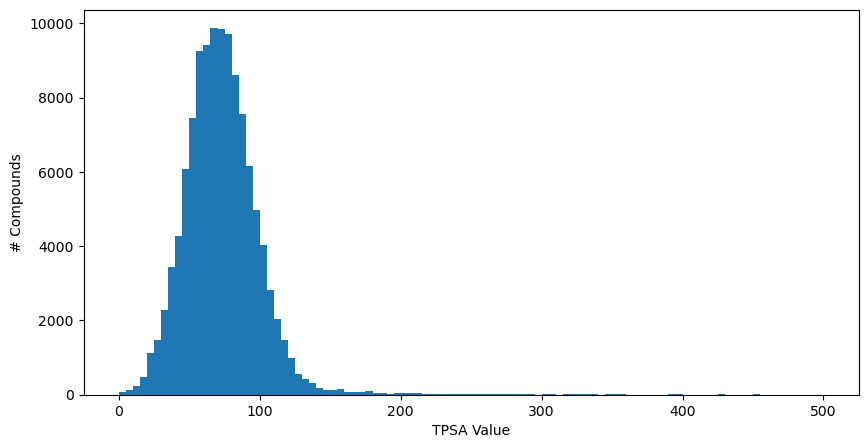

In [33]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

num_bins = 100
fig = plt.figure(figsize=(10,5))
# fig, ax = plt.subplots()
 
# the histogram of the data
n, bins, patches = plt.hist(df_metadata.TPSA, num_bins, density=False, range=[0, 500],)
# We can set the number of bins with the *bins* keyword argument.
plt.xlabel('TPSA Value');
plt.ylabel('# Compounds');
# ax.set_title('Histogram of normal distribution sample: '
#              fr'$\mu={mu:.0f}$, $\sigma={sigma:.0f}$')
# axs[1].hist(dist2, bins=n_bins)

In [43]:
df_metadata['permiation'] = 0
df_metadata.permiation[df_metadata.TPSA >= 100] = 1

/tmp/ipykernel_1797392/1518050329.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metadata.permiation[df_metadata.TPSA >= 100] = 1


In [47]:
df_tpsa['permiation'] = 0
df_tpsa.permiation[df_metadata.TPSA >= 100] = 1

/tmp/ipykernel_1797392/24812782.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tpsa.permiation[df_metadata.TPSA >= 100] = 1


In [46]:
df_metadata.permiation.value_counts()

0    102417
1     14274
Name: permiation, dtype: int64

In [52]:
# df_metadata.tail()
# df_tpsa.tail()

## Write to output files

In [53]:
print(f" OUTPUT - compound Metadata + TPSA Cleaned File : {compoundMetadataTPSACleanFile}")
print(f" OUTPUT - compound TPSA Clean File              : {compoundTPSACleanFile}\n")

 OUTPUT - compound Metadata + TPSA Cleaned File : ./output_11102023/compound_metadata_tpsa_clean.csv
 OUTPUT - compound TPSA Clean File              : ./output_11102023/compound_TPSA_clean.csv



### `./output/compound_metadata_tpsa_clean.csv`

In [54]:
print(f"--> compound Metadata + TPSA Cleaned File    : {compoundMetadataTPSACleanFile}\n")

--> compound Metadata + TPSA Cleaned File    : ./output_11102023/compound_metadata_tpsa_clean.csv



In [55]:
df_metadata.to_csv(compoundMetadataTPSACleanFile, index = False)

### `./output/compound_tpsa_clean.csv`

In [56]:
print(f"--> compound TPSA Clean File                 : {compoundTPSACleanFile}\n")

--> compound TPSA Clean File                 : ./output_11102023/compound_TPSA_clean.csv



In [58]:
df_tpsa.to_csv(compoundTPSACleanFile, index = False, columns=['JCP2022', 'TPSA', 'permiation'])

In [72]:
# del df_tpsa
# del df_metadata
# del df_nans,
# del df_smiles
# del df_tpsa_zero
# del df_tpsa_nan
# del df_tpsa_inv
# del df_md_zero
# del df_md_nan
# del df_md_inv
# del df

### check the files we just wrote

In [62]:
df_tpsa = pd.read_csv(compoundTPSACleanFile)
df_tpsa.info()
df_tpsa.head()
df_tpsa.tail()
df_tpsa.permiation.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116691 entries, 0 to 116690
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   JCP2022     116691 non-null  object 
 1   TPSA        116691 non-null  float64
 2   permiation  116691 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 2.7+ MB


,JCP2022,TPSA,permiation
0,JCP2022_000001,63.49,0
1,JCP2022_000002,35.83,0
2,JCP2022_000003,73.72,0
3,JCP2022_000004,67.23,0
4,JCP2022_000005,84.89,0


,JCP2022,TPSA,permiation
116686,JCP2022_116749,159.30,1
116687,JCP2022_116750,66.32,0
116688,JCP2022_116751,85.30,0
116689,JCP2022_116752,71.95,0
116690,JCP2022_116753,54.29,0


0    102417
1     14274
Name: permiation, dtype: int64

In [65]:
df_metadata = pd.read_csv(compoundMetadataTPSACleanFile)
df_metadata.info()
# df_metadata.head(5)
df_metadata.tail(5)
df_metadata.permiation.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116691 entries, 0 to 116690
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Metadata_JCP2022   116691 non-null  object 
 1   Metadata_InChIKey  116691 non-null  object 
 2   Metadata_InChI     116691 non-null  object 
 3   smiles             116691 non-null  object 
 4   TPSA               116691 non-null  float64
 5   lnTPSA             116691 non-null  float64
 6   log10TPSA          116691 non-null  float64
 7   permiation         116691 non-null  int64  
dtypes: float64(3), int64(1), object(4)
memory usage: 7.1+ MB


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,smiles,TPSA,lnTPSA,log10TPSA,permiation
116686,JCP2022_116749,ZZZRUAITSXLWBH-UHFFFAOYSA-N,InChI=1S/C23H27N3O7/c1-25(2)12-5-6-13(27)15-10...,CN(C)C3C(=O)C(C(=N)O)C(=O)C4(O)C(=O)C2C(=O)c1c...,159.30,5.070789,2.202216,1
116687,JCP2022_116750,ZZZTXDPKNAOZPM-UHFFFAOYSA-N,InChI=1S/C22H27N3O2/c1-14-18(22(27)24-15(2)23-...,Cc4nc(C)c(CCC(=O)N(C1CC1)C2CCCc3ccccc23)c(O)n4,66.32,4.194492,1.821645,0
116688,JCP2022_116751,ZZZUOLMMTJKOGE-UHFFFAOYSA-N,InChI=1S/C19H17N5O2/c1-23-9-6-13-7-10-24(19(26...,CN4C=CC3C=CN(CCN=C(O)c2cnc1ccccc1n2)C(=O)C=34,85.30,4.446174,1.930949,0
116689,JCP2022_116752,ZZZZIBSVRUABIA-UHFFFAOYSA-N,InChI=1S/C19H13F6N3O2S/c1-11-26-6-5-17(27-11)1...,Cc1nccc(n1)c2cccc(c2)NS(=O)(=O)c3cc(cc(c3)C(F)...,71.95,4.275971,1.857031,0
116690,JCP2022_116753,ZZZZVNLQWWXZTQ-UHFFFAOYSA-N,InChI=1S/C14H20N2O3/c1-18-13-5-3-2-4-12(13)14(...,COc1ccccc1C(O)=NCCN2CCOCC2,54.29,3.994340,1.734720,0


0    102417
1     14274
Name: permiation, dtype: int64

# Drop TPSA == 0 rows from df_pharamcophore file 

### Re-read Pharmacophore fingerprint 
(Sparse Bit Vector format)  `./output/cp_compound_pharmacophores_sparsebitvec.pkl`  and check it

In [73]:
print(compoundPharmacophoreFile)

./output_11102023/_compound_pharmacophores_sparse.pkl


In [73]:
df = pd.read_pickle(compoundPharmacophoreFile)
df.info()
df.head(10)
df.tail(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116751 entries, 0 to 116750
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   JCP2022           116751 non-null  object
 1   pharmacophore_fp  116751 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


,JCP2022,pharmacophore_fp
0,JCP2022_000001,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, ..."
1,JCP2022_000002,"[0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ..."
2,JCP2022_000003,"[0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
3,JCP2022_000004,"[1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."
4,JCP2022_000005,"[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
5,JCP2022_000006,"[1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
6,JCP2022_000007,"[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
7,JCP2022_000008,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, ..."
8,JCP2022_000009,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, ..."
9,JCP2022_000010,"[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


,JCP2022,pharmacophore_fp
116741,JCP2022_116744,"[0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
116742,JCP2022_116745,"[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, ..."
116743,JCP2022_116746,"[0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
116744,JCP2022_116747,"[0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, ..."
116745,JCP2022_116748,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
116746,JCP2022_116749,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, ..."
116747,JCP2022_116750,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, ..."
116748,JCP2022_116751,"[0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, ..."
116749,JCP2022_116752,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
116750,JCP2022_116753,"[0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, ..."


In [74]:

print(type(df.at[0, 'pharmacophore_fp']), len(df.at[0, 'pharmacophore_fp']),  df.at[0, 'pharmacophore_fp'])
print(type(df.loc[0].pharmacophore_fp)  , len(df.loc[0].pharmacophore_fp)  ,  df.loc[0].pharmacophore_fp)
print(type(df.iloc[0].pharmacophore_fp) , len(df.iloc[0].pharmacophore_fp) ,  df.iloc[0].pharmacophore_fp)
# print(type(df[0].pharmacophore_fp) , len(df[0].pharmacophore_fp) ,  df[0].pharmacophore_fp)


<class 'rdkit.DataStructs.cDataStructs.SparseBitVect'> 1032 <rdkit.DataStructs.cDataStructs.SparseBitVect object at 0x7f4775000130>
<class 'rdkit.DataStructs.cDataStructs.SparseBitVect'> 1032 <rdkit.DataStructs.cDataStructs.SparseBitVect object at 0x7f4775000130>
<class 'rdkit.DataStructs.cDataStructs.SparseBitVect'> 1032 <rdkit.DataStructs.cDataStructs.SparseBitVect object at 0x7f4775000130>


In [75]:
df[df['JCP2022'].isna()]
len(df)
df[df['pharmacophore_fp'].isna()]
len(df)


,JCP2022,pharmacophore_fp


116751

,JCP2022,pharmacophore_fp


116751

In [76]:
del df

### Read pharamcophore file

In [76]:
df_pharmacophores = pd.read_pickle(compoundPharmacophoreFile)
df_pharmacophores.info()
df_pharmacophores.head(3)
df_pharmacophores.tail(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116751 entries, 0 to 116750
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   JCP2022           116751 non-null  object
 1   pharmacophore_fp  116751 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


,JCP2022,pharmacophore_fp
0,JCP2022_000001,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, ..."
1,JCP2022_000002,"[0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ..."
2,JCP2022_000003,"[0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."


,JCP2022,pharmacophore_fp
116748,JCP2022_116751,"[0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, ..."
116749,JCP2022_116752,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
116750,JCP2022_116753,"[0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, ..."


### drop df_pharmacophore rows where corresponding  TPSA == 0

In [88]:
df_pharmacophores.drop(index=md_drop_indices, inplace=True)
len(df_pharmacophores)
df_pharmacophores


116691

,JCP2022,pharmacophore_fp
0,JCP2022_000001,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, ..."
1,JCP2022_000002,"[0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ..."
2,JCP2022_000003,"[0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
3,JCP2022_000004,"[1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."
4,JCP2022_000005,"[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
...,...,...
116746,JCP2022_116749,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, ..."
116747,JCP2022_116750,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, ..."
116748,JCP2022_116751,"[0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, ..."
116749,JCP2022_116752,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."


In [93]:
df_pharmacophores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116691 entries, 0 to 116750
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   JCP2022           116691 non-null  object
 1   pharmacophore_fp  116691 non-null  object
dtypes: object(2)
memory usage: 2.7+ MB


#### `./output/cp_compound_pharmacophores_sparse_clean.pkl`

In [103]:
print(f" compound Pharmacophore Clean Pickle File       : {compoundPharmacophoreCleanFile}")

 compound Pharmacophore Clean Pickle File       : ./output/cp_compound_pharmacophores_sparse_clean.pkl


In [104]:
df_pharmacophores.to_pickle(compoundPharmacophoreCleanFile)

# Convert Pharmacophore FPs from Sparse BitVector to dense matrix

In [126]:
from utils import fingerprint_to_sparse_matrix

In [119]:
print(f" compound Pharmacophore Sparse File       : {compoundPharmacophoreFile}")
print(f" compound Pharmacophore Sparse Clean File : {compoundPharmacophoreCleanFile}")
print(f" compound Pharmacophore Dense File        : {compoundPharmacophoreDenseFile}")
print(f" compound Pharmacophore Dense Zipped File : {compoundPharmacophoreDenseZipFile}")

 compound Pharmacophore Sparse File       : ./output/cp_compound_pharmacophores_sparse.pkl
 compound Pharmacophore Sparse Clean File : ./output/cp_compound_pharmacophores_sparse_clean.pkl
 compound Pharmacophore Dense File        : ./output/cp_compound_pharmacophores_dense.npy
 compound Pharmacophore Dense Zipped File : ./output/cp_compound_pharmacophores_dense.npz


In [124]:
# del df
df = pd.read_pickle(compoundPharmacophoreCleanFile)


In [125]:
print(df.info())
print(df.head(5))
print(df.tail(5))
type(df.loc[0].pharmacophore_fp)

df_nan = df[df['pharmacophore_fp'].isna()]
len(df_nan)

df.loc[20:26]

<class 'pandas.core.frame.DataFrame'>
Index: 116691 entries, 0 to 116750
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   JCP2022           116691 non-null  object
 1   pharmacophore_fp  116691 non-null  object
dtypes: object(2)
memory usage: 2.7+ MB
None
          JCP2022                                   pharmacophore_fp
0  JCP2022_000001  [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, ...
1  JCP2022_000002  [0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...
2  JCP2022_000003  [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...
3  JCP2022_000004  [1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...
4  JCP2022_000005  [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...
               JCP2022                                   pharmacophore_fp
116746  JCP2022_116749  [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, ...
116747  JCP2022_116750  [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, ...
116748  JCP2022_116751  [0

rdkit.DataStructs.cDataStructs.SparseBitVect

0

,JCP2022,pharmacophore_fp
20,JCP2022_000021,"[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, ..."
21,JCP2022_000022,"[1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, ..."
22,JCP2022_000023,"[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, ..."
23,JCP2022_000024,"[1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, ..."
24,JCP2022_000025,"[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
25,JCP2022_000026,"[0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
26,JCP2022_000027,"[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, ..."


In [127]:
start, end  = 0, 0 

for i in range(0, 12, 1):
    start = 10000 * i 
    end   +=10000
    print(f" {datetime.now().strftime('%X.%f')} | from {start} to {end}")
    csr_out, output_out = fingerprint_to_sparse_matrix(df, start, end, ncols=1032)
    if i == 0:
        dense_mat = csr_out.todense();
    else :
        dense_mat = np.concatenate([dense_mat, csr_out.todense()]);
    print(f" {datetime.now().strftime('%X.%f')} | shape of dense matrix is : {dense_mat.shape}" )

 14:28:34.264161 | from 0 to 10000
 14:28:38.758338 | shape of dense matrix is : (10000, 1032)
 14:28:38.758464 | from 10000 to 20000
 14:28:43.159142 | shape of dense matrix is : (20000, 1032)
 14:28:43.159263 | from 20000 to 30000
 14:28:47.518087 | shape of dense matrix is : (30000, 1032)
 14:28:47.518227 | from 30000 to 40000
 14:28:51.880139 | shape of dense matrix is : (40000, 1032)
 14:28:51.880281 | from 40000 to 50000
 14:28:56.265560 | shape of dense matrix is : (50000, 1032)
 14:28:56.265689 | from 50000 to 60000
 14:29:00.725288 | shape of dense matrix is : (60000, 1032)
 14:29:00.725419 | from 60000 to 70000
 14:29:05.104887 | shape of dense matrix is : (70000, 1032)
 14:29:05.105023 | from 70000 to 80000
 14:29:09.425635 | shape of dense matrix is : (80000, 1032)
 14:29:09.425769 | from 80000 to 90000
 14:29:13.763285 | shape of dense matrix is : (90000, 1032)
 14:29:13.763413 | from 90000 to 100000
 14:29:18.142645 | shape of dense matrix is : (100000, 1032)
 14:29:18.14

In [128]:
print(f" Dense matrix - shape: {dense_mat.shape}  type:  {type(dense_mat)}")
# del dense_mat,csr_out,csr_matrix

 Dense matrix - shape: (116691, 1032)  type:  <class 'numpy.matrix'>


In [129]:
print(f" compound Pharmacophore Dense File : {compoundPharmacophoreDenseFile}")
print(f" compound Pharmacophore Dense Zipped File : {compoundPharmacophoreDenseZipFile}")

 compound Pharmacophore Dense File : ./output/cp_compound_pharmacophores_dense.npy
 compound Pharmacophore Dense Zipped File : ./output/cp_compound_pharmacophores_dense.npz


In [130]:
# np.save(compoundPharmacophoreDenseFile, dense_mat)

In [131]:
np.savez_compressed(compoundPharmacophoreDenseZipFile, dense_mat = dense_mat)

### Test zipped dense matrix

In [132]:
loaded = np.load(compoundPharmacophoreDenseZipFile)
print(np.array_equal(dense_mat, loaded['dense_mat']))

True


In [133]:
# print(output_out)
type(loaded['dense_mat']), loaded['dense_mat'].shape
# loaded['dense_mat']

(numpy.ndarray, (116691, 1032))

In [134]:
del loaded